In [1]:
import numpy as np
import matplotlib.pyplot as plt
from biped_mpc_model import BipedModel
import json
import munch
from biped_mpc_opt_utils import get_Sp, get_Up, get_Sz, get_Uz, get_Sv, get_Uv, get_Sa, get_Ua
import copy

In [3]:
config_path = "biped_config.json"
with open(config_path) as json_file:
    config = json.load(json_file)
config = munch.munchify(config)

model = BipedModel(config)

Sp = get_Sp(N=config.preview_horizon)
Sz = get_Sz(N=config.preview_horizon)
Sv = get_Sv(N=config.preview_horizon)
Sa = get_Sa(N=config.preview_horizon)
Up = get_Up(N=config.preview_horizon)
Uz = get_Uz(N=config.preview_horizon)
Uv = get_Uv(N=config.preview_horizon)
Ua = get_Ua(N=config.preview_horizon)

In [4]:
model.reset()
X_jerks_init, X_next_foot_pos_init, Y_jerks_init, Y_next_foot_pos_init = model.get_control(solver="cvxopt", init=True)
Xpos_init = Sp@model.stateX + Up@X_jerks_init
Ypos_init = Sp@model.stateY + Up@Y_jerks_init
Xvel_init = Sv@model.stateX + Uv@X_jerks_init
Yvel_init = Sv@model.stateY + Uv@Y_jerks_init
CoPX_init = Sz@model.stateX + Uz@X_jerks_init
CoPY_init = Sz@model.stateY + Uz@Y_jerks_init

primal objective: -0.688398670626961


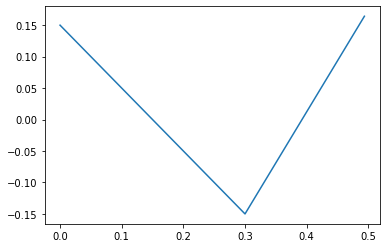

In [5]:
X_next_foot_pos_init = np.vstack((np.zeros((1, 1)), X_next_foot_pos_init))
Y_next_foot_pos_init = np.vstack((np.ones((1, 1))*0.15, Y_next_foot_pos_init))

plt.plot(X_next_foot_pos_init, Y_next_foot_pos_init)

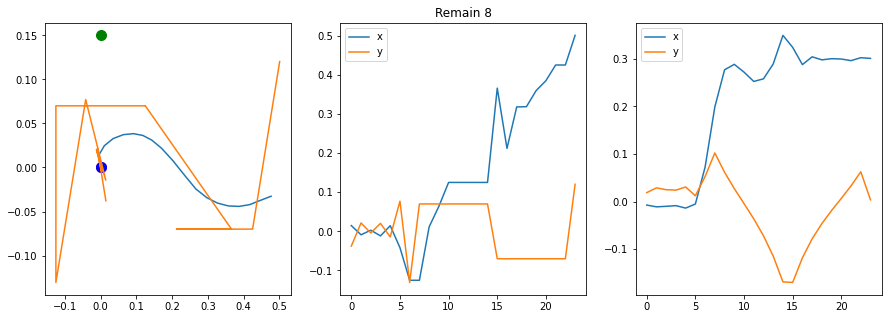

In [6]:
swing_foot_pos = model.get_swing_foot_pos()
next_step_planned = np.array([X_next_foot_pos_init[0][0], Y_next_foot_pos_init[0][0]])

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
ax[0].plot(Xpos_init, Ypos_init)
ax[0].plot(CoPX_init, CoPY_init)
ax[0].scatter(model.get_CoP()[0], model.get_CoP()[1], color="red", s=100)
ax[0].scatter(swing_foot_pos[0], swing_foot_pos[1], color="blue", s=100)
ax[0].scatter(next_step_planned[0], next_step_planned[1], color="green", s=100)

ax[1].plot(CoPX_init, label='x')
ax[1].plot(CoPY_init, label='y')
ax[1].legend()
ax[1].set_title("Remain {}".format(model.tPf - model.step_count))

ax[2].plot(Xvel_init, label='x')
ax[2].plot(Yvel_init, label='y')
ax[2].legend()
plt.show()

In [7]:
comX = []
comY = []
velX = []
velY = []
accX = []
accY = []
copX = []
copY = []
leftFoot = []
rightFoot = []
supportFoot = []
nextFoot = []
x_future_pos = []
y_future_pos = []
x_future_cop = []
y_future_cop = []

stateX = []
stateY = []

model.reset()

for i in range(200):
    # Get control and next foot steps
    if i < 8:
        init = True
    else:
        init = False
    
    comX.append(model.stateX[0][0])
    comY.append(model.stateY[0][0])
    velX.append(model.stateX[1][0])
    velY.append(model.stateY[1][0])
    accX.append(model.stateX[2][0])
    accY.append(model.stateY[2][0])
    copX.append(model.get_CoP()[0])
    copY.append(model.get_CoP()[1])
    leftFoot.append(copy.deepcopy(model.left_foot_pos))
    rightFoot.append(copy.deepcopy(model.right_foot_pos))
    supportFoot.append(copy.deepcopy(model.get_support_foot_pos()))
    
    stateX.append(model.stateX)
    stateY.append(model.stateY)
    
    X_jerks, X_next_foot_pos, Y_jerks, Y_next_foot_pos = model.get_control(solver="cvxopt", init=init)
    next_step_planned = np.array([X_next_foot_pos[0][0], Y_next_foot_pos[0][0]])
    nextFoot.append(next_step_planned)
    swing_foot_pos = model.get_swing_foot_pos()
    
    Xpos = Sp@model.stateX + Up@X_jerks
    Ypos = Sp@model.stateY + Up@Y_jerks
    Xvel = Sv@model.stateX + Uv@X_jerks
    Yvel = Sv@model.stateY + Uv@Y_jerks
    Xacc = Sa@model.stateX + Ua@X_jerks
    Yacc = Sa@model.stateY + Ua@Y_jerks
    CoPX = Sz@model.stateX + Uz@X_jerks
    CoPY = Sz@model.stateY + Uz@Y_jerks
    
    x_future_pos.append(Xpos)
    y_future_pos.append(Ypos)
    x_future_cop.append(CoPX)
    y_future_cop.append(CoPY)
    
#     fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
#     ax[0].plot(Xpos, Ypos)
#     ax[0].plot(CoPX, CoPY)
#     ax[0].set_title("step {}".format(i))
#     ax[0].scatter(model.get_CoP()[0], model.get_CoP()[1], color="red", s=100)
#     ax[0].scatter(swing_foot_pos[0], swing_foot_pos[1], color="blue", s=100)
#     ax[0].scatter(next_step_planned[0], next_step_planned[1], color="green", s=100)
    
#     ax[1].plot(CoPX, label='x')
#     ax[1].plot(CoPY, label='y')
#     ax[1].legend()
#     ax[1].set_title("Remain {}".format(model.tPf - model.step_count))

#     ax[2].plot(Xvel, label='x')
#     ax[2].plot(Yvel, label='y')
#     ax[2].legend()
#     plt.show()
#     model.step(np.expand_dims(X_jerks_init[i, :], axis=1), 
#                np.expand_dims(Y_jerks_init[i, :], axis=1), 
#                next_step_planned)
    
    model.step(X_jerks[:1, :], Y_jerks[:1, :], next_step_planned)
#     print("step: {}".format(model.step_count))

primal objective: -0.688398670626961
primal objective: -6.248827467131552
primal objective: -0.9073487689156032
primal objective: -1.7508999767613573
primal objective: -0.5456000631948295
primal objective: -5.237349539746937
primal objective: -9.14775418543623
primal objective: -75.98391665256163
primal objective: -427.1287856005941
primal objective: -35.92806225451313
primal objective: -20.510725974656268
primal objective: -49.461727923948594
primal objective: -29.334193122633963
primal objective: -46.391105005643944
primal objective: -114.8409961428278
primal objective: -272.8997269872841
primal objective: -594.3335179071082
primal objective: -239.71669298097837
primal objective: -115.16632179975329
primal objective: -68.35235377208578
primal objective: -48.04291926208774
primal objective: -48.62927072578063
primal objective: -73.20796699005108
primal objective: -133.56603942107873
primal objective: -79.21649018166036
primal objective: -51.7536998196946
primal objective: -38.16056457

### Walking Movement Plot

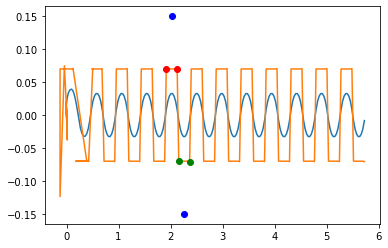

In [8]:
plt.plot(comX, comY)
plt.plot(copX, copY)

# First time step in current foot step
plt.plot(copX[72], copY[72], 'ro')
# Last time step in current foot step
plt.plot(copX[79], copY[79], 'ro')
# Support foot position
plt.plot(supportFoot[75][0], supportFoot[75][1], 'bo')

# First time step in current foot step
plt.plot(copX[80], copY[80], 'go')
# Last time step in current foot step
plt.plot(copX[87], copY[87], 'go')
# Support foot position
plt.plot(supportFoot[85][0], supportFoot[85][1], 'bo')

### Right Foot initial and target states
The initial state is the first state of each foot step and the target state is the first state of the next foot step in the body coordinate of the current foot step.

In [8]:
initX = copy.deepcopy(stateX[80])
initY = copy.deepcopy(stateY[80])
origin = copy.deepcopy(supportFoot[85])

initX[0] -= origin[0]
initY[0] -= origin[1]

termX = copy.deepcopy(stateX[88])
termY = copy.deepcopy(stateY[88])

termX[0] -= origin[0]
termY[0] -= origin[1]

print("Initial X state: {} \nInitial Y state: {}".format(initX[:, 0], initY[:, 0]))
print("Terminal X state: {} \nTerminal Y state: {}".format(termX[:, 0], termY[:, 0]))
print("Support foot position: {}".format(origin))

Initial X state: [-0.106262    0.30000358 -0.00164346] 
Initial Y state: [ 0.14177463 -0.15565824  0.60600913]
Terminal X state: [ 0.13373765  0.30000358 -0.00164335] 
Terminal Y state: [ 0.15822537  0.15565824 -0.60600913]
Support foot position: [ 2.26327646 -0.15      ]


### Left foot initial and target states

In [9]:
initX = copy.deepcopy(stateX[72])
initY = copy.deepcopy(stateY[72])
origin = copy.deepcopy(supportFoot[75])

initX[0] -= origin[0]
initY[0] -= origin[1]

termX = copy.deepcopy(stateX[80])
termY = copy.deepcopy(stateY[80])

termX[0] -= origin[0]
termY[0] -= origin[1]

print("Initial X state: {} \nInitial Y state: {}".format(initX[:, 0], initY[:, 0]))
print("Terminal X state: {} \nTerminal Y state: {}".format(termX[:, 0], termY[:, 0]))
print("Support foot position: {}".format(origin))

Initial X state: [-0.10626204  0.30000359 -0.00164435] 
Initial Y state: [-0.14177463  0.15565824 -0.60600913]
Terminal X state: [ 0.13373761  0.30000358 -0.00164346] 
Terminal Y state: [-0.15822537 -0.15565824  0.60600913]
Support foot position: [2.02327686 0.15      ]


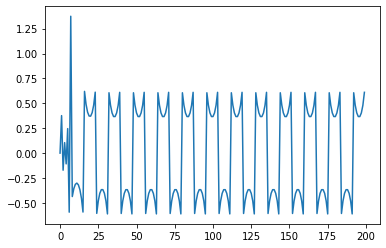

In [10]:
plt.plot(accY)

In [11]:
data_list = [comX, comY, copX, copY, leftFoot, rightFoot, nextFoot, x_future_pos, y_future_pos, x_future_cop, y_future_cop]
data_list.extend([velX, velY, accX, accY])

In [12]:
np.save('data_biped.npy', data_list)

### Compare the result of MPC at the first time step with actual movement

No handles with labels found to put in legend.


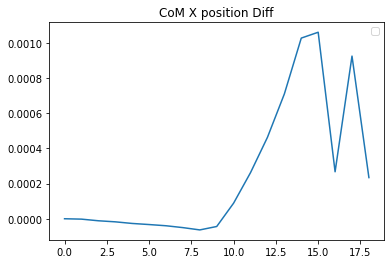

In [9]:
plt.plot(np.array(comX[1:20]) - Xpos_init[:19][:, 0])
plt.title("CoM X position Diff")
plt.legend()
plt.show()

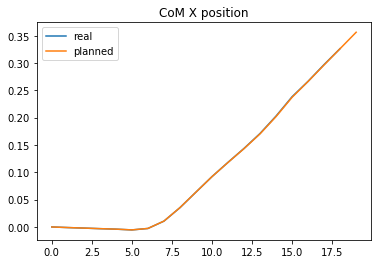

In [15]:
plt.plot(comX[1:20], label="real")
plt.plot(Xpos_init[:20], label="planned")
plt.title("CoM X position")
plt.legend()
plt.show()

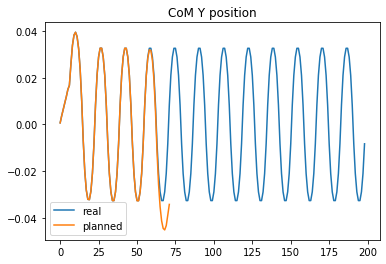

In [12]:
plt.plot(comY[1:], label="real")
plt.plot(Ypos_init, label="planned")
plt.title("CoM Y position")
plt.legend()
plt.show()

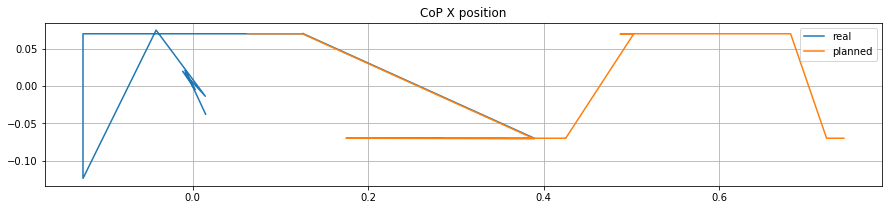

In [18]:
plt.figure(figsize=(15, 3))
plt.plot(copX[1:20], copY[1:20], label="real")
# plt.plot(CoPX_init[:20], label="planned")
plt.plot(x_future_cop[9], y_future_cop[9], label="planned")
plt.title("CoP X position")
plt.grid()
plt.legend()
plt.show()

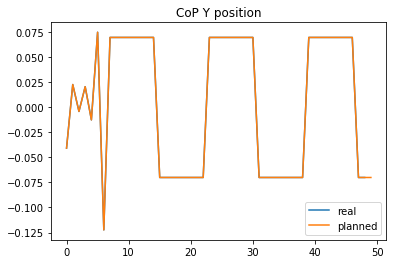

In [14]:
plt.plot(copY[1:50], label="real")
plt.plot(CoPY_init[:50], label="planned")
plt.title("CoP Y position")
plt.legend()
plt.show()